# Western Monarch - Suitablity model for Sighting and Habitat

## 1.
### Name: Shutong Li
### PID: A14625906
### Team members: Me myself and I


## 2. Project goals:
Project Overview (storymap):https://ucsdonline.maps.arcgis.com/apps/Cascade/index.html?appid=226873d8814740868e66a59888c0d466
<br>

The project is an exploratory approach towards the potential use of a geospatial data with minimal features. Therefore questions are asked along the exploration process rather than predetermined prior to the exploration. The product of this project is intended for anybody who takes interest in monarch butterfly in general or specifically about the preservation effort. 
<br>
The quesitons that the project eventually decided to tackle are:
1. What is the volume of monarch traffic in each county
1. Where are the best sighting locations to see monarchs
1. What are all the potential habitats for monarchs in our study area?

## 3. Background and Literature
* Monarch migration info: https://www.fs.fed.us/wildflowers/pollinators/Monarch_Butterfly/migration/index.shtml
<br>
* Monarch general background: https://www.fws.gov/cno/es/monarch/monarch.cfm
<br>
* Suitability model for monarchs based on habitat information: Dilts, et al. “Host Plants and Climate Structure Habitat Associations of the Western Monarch Butterfly”  frontiers in Ecology and Evolution. 2019. Digital. Accessed 2019-6-6
<br>
* MaxTENT model to construct suitability model: Steven J. Phillips, Miroslav Dudík, Robert E. Schapire. [Internet] Maxent software for modeling species niches and distributions (Version 3.4.1). Available from url: http://biodiversityinformatics.amnh.org/open_source/maxent/. Accessed on 2019-6-6.

The fish and wildlife monarch website and the US forest service provides me with the basic knowledge required to understand preliminary phenomenons exhibited in the dataset (migration path, seasonality of the path, environment types that are beneficial to monarch etc)
<br>
The MaxTENT model along with the Dilts et al provides me with detailed information on how spatial data is used to train suitability model that has predictive power.

## 4. Used Library
* PANDAS and numpy: used for data wrangling, no need to explain why these two are involved
* arcgis.WebMap for some web scene representation
* Pysal for spatial statistics
* matplotlib for non-spatial statistic visualization
* arcgis.aggregate_points for point aggregation
* geopandas for when arcgis doesn't work and for spatial statistical anlaysis
* AND LAST BUT NOT LEAST: ArcGIS PRO!!!!!!

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from arcgis import aggregate_points
import pysal as ps
from arcgis.mapping import WebMap
from arcgis import GIS

In [4]:
gis = GIS()

In [5]:
#gis = GIS(username = 'shl636_UCSDOnline')

**Difference from the proposal:** The one thing that I did not expect myself using is ArcGIS pro. Since raster algebra in python api is completely broken, I was glad to learn that our account are authorized to use ArcGIS pro. The array of tools provided by ArcGIS pro is the bread and butter for the last two anlaysis in this project.

## 5. Dataset description

**Dataset overview**: dataset is compile by US Fish and Wildlife Service in collaboration with the Xerces Society. Dataset contains inforation on individual monarch/milkweed sightings along with phenological information of the subject.
<br>
**Time elapse**: 1846 - 2015
<br>
**Features**: Datetime of the sighting. Geographical Location of the sighting. Genus and specie of the subject sighted. Lifestage of the subject if it is a monarch sighting. 
<br>
**Geographical Extent**: Oregon, Idaho, Washington, California, Arizona, Nevada, New Mexico, Wyoming*, Montana,  Colorado


## 6. Data Cleaning and Filtering

In [6]:
#will take a while, it is a large dataset
monarch_path = 'western_monarch/milkweed_monarch.xlsx'
df = pd.read_excel(monarch_path)
#extract basic columns
basic_columns = ['PrimaryKey', 'Genus', 'Species', 'ScientificName', 'VernacularName', 'RecordDate', 'RecordYear', 'State', 'County', 'Latitude', 'Longitude']
#monarch_basic is the dataset with features of interest
monarch_basic = df.copy()[basic_columns]

#monarch_basic_current is the dataset with data recorded after 2010
monarch_basic_current = monarch_basic.loc[lambda x: (x['RecordYear'] >= 2010)]
#very few nulls, drop them
monarch_basic_current_nonull = monarch_basic_current.dropna(subset = ['RecordDate'])
#transform monarch_basic into a sdf
monarch_basic_sdf = pd.DataFrame.spatial.from_xy(monarch_basic_current_nonull.copy(), x_column = 'Longitude', y_column = 'Latitude')
monarch_basic_sdf_cleaned = monarch_basic_sdf.copy().replace(np.nan, '')

non_monarch_sdf = monarch_basic_sdf_cleaned.copy().loc[(monarch_basic_sdf_cleaned['ScientificName'] != 'Danaus plexippus') & 
                                                       (monarch_basic_sdf_cleaned['ScientificName'] != 'danaus plexippus')]
#non_monarch_sdf.spatial.to_featurelayer(title = 'milkweed_locations', gis = gis, tags = ['project', 'monarch'])

#monarch butterfly records before 2010 (used in analysis later on)
monarch_basic_past = monarch_basic.loc[lambda x: (x['RecordYear'] < 2010)]
monarch_basic_past_nonull = monarch_basic_past.dropna(subset = ['RecordDate'])
monarch_past_sdf = pd.DataFrame.spatial.from_xy(monarch_basic_past_nonull.copy(), x_column = 'Longitude', y_column = 'Latitude')
monarch_past_sdf_cleaned = monarch_past_sdf.copy().replace(np.nan, '')

***Cleaning Log:***
<br>
monarch_basic_current is a dataframe focuses only on monarch and milkweed record made after 2010. Similarly, monarch_basic_past are monarch and milkweed records made before 2010.
The eventual spatially-enabled dataframe of this dataset is cleaned with the following procedures:
1. removing the rows with invalid record date. Very few nulls and can't really impute
1. replace empty entries with empty strings. Due to the fact that the dataset is an aggregation of different datasets, feature space is almost always larger than the information held in every individual record(row), leaving many empty entries  

only_monarch_sdf is intrinsically clean because it is derived from monarch_basic_sdf_cleaned.
dataset consists only of monarch data recorded after 2010
<br>
It is not necessay for the feature 'Monarch_YN'  to be included for filtering explicit monarch records because it is the same organization that has this feature that comes up the monarch sighting data

***Feature generation:*** transform the datetime in the dataset into four seasons (spring, summer, fall, winter)

In [7]:
#tag_season() elaborates on the datetime column to seasons to better represent monarch's relationship with the time in year
def tag_season(month):
    if (month >= 3) and (month <= 5):
        return 1
    elif (month >= 6) and (month <= 8):
        return 2
    elif (month >= 9) and (month <= 11):
        return 3
    else:
        return 4

In [8]:
past_only_monarch_sdf = monarch_past_sdf_cleaned.copy().loc[(monarch_past_sdf_cleaned['ScientificName'] == 'Danaus plexippus') | 
                                                       (monarch_past_sdf_cleaned['ScientificName'] == 'danaus plexippus')]
past_only_monarch_sdf['RecordMonth'] = past_only_monarch_sdf['RecordDate'].apply(lambda x: str(x)[5:7])
past_only_monarch_sdf['RecSeason'] = past_only_monarch_sdf['RecordMonth'].astype('int64').apply(tag_season)

only_monarch_sdf = monarch_basic_sdf_cleaned.copy().loc[(monarch_basic_sdf_cleaned['ScientificName'] == 'Danaus plexippus') | 
                                                       (monarch_basic_sdf_cleaned['ScientificName'] == 'danaus plexippus')]
only_monarch_sdf['RecordMonth'] = only_monarch_sdf['RecordDate'].apply(lambda x: str(x)[5:7])
only_monarch_sdf['RecSeason'] = only_monarch_sdf['RecordMonth'].astype('int64').apply(tag_season)

In [9]:
#saving sdf to arcgis online. Saving two so that I can use the arcgis online renderer instead of render them locally 
#everytime I get it from content

#past_only_monarch_sdf.spatial.to_featurelayer(title = 'past_monarch_locations_by_season', gis = gis, tags = ['project', 'monarch'])
#only_monarch_sdf.spatial.to_featurelayer(title = 'monarch_locations_by_season', gis = gis, tags = ['project', 'monarch'])
#only_monarch_sdf.spatial.to_featurelayer(title = 'monarch_locations_by_density', gis = gis, tags = ['project', 'monarch'])

## 7. Descriptive Statistics

**See my analysis section:** The nature of this project is extremely exploratory. I did not start off knowing which feature to focus on nor what type of operation I will perform on them. Therefore specific statistics and visualizations are described in detail in the next section about my analysis.

## 8. Anlaysis
### Anlaysis OUTLINE
1. #### migration trend (failed)
1. #### population density of monarch
1. #### best sighting spots for monarchs
1. #### using spatially explicit model to predict monarch habitats

## Seasonality of the sighting (failed)
***Question:*** Can we extract a trend by plotting out points and classify them by their seasonal feature?

In [10]:
from arcgis.mapping import WebMap
monarch_all_season_lyr = gis.content.get('d570e2111c4e46e087b79a2bdd2e27a2')
wm_seasons = WebMap(monarch_all_season_lyr)
wm_seasons

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

The red dots in the map are monarch sightings recorded during summer, orange are ones during fall, green are ones during spring, and blue are ones during winter. (most blue dots are covered by dots of other color, zoom in on california and they will show up)
<br>
Contrary to the assumption that seasonality is clear in the dataset, the map indicates that there a quite a lot of noises in the trend. However, there is still a vague flow of the points that we can make of - western monarchs goes to west side of rocky mountain during summer (Red clusters around rocky mountain), and migrate via different paths to converge in California during winter (blue clusters in california). Orange and green dots cluster together and are placed between red points and blue points because monarchs migrate to and from California every year, amounting to some location seeing monarch twice a year on their two way trip.
<br> 
The vague pattern from the data conincides with the general consensus on western monarch migration paths shown below.
<img src="Cache/fallmigrationmap.jpg">

Only data points recorded during winter exhibit a very strict pattern(cluster) around california. This makes sense because California is monarch's overwintering site and anywhere north of state is not ideal for survival. Can we only focus on analyzing records made during winter?
<br>
<br>
**Change of question**: Is there any significant shift in the location of monarch's overwintering site between past and present?
<br>
**Rationale**: monarch is dying due to temperature change and geographical change(expansion of farms housing area etc), does it affect their overwintering site and if so are they adapting?
<br>
**Definition**: past and present is defined as years before and after 2010. 
<br>
**Original Plan**: Extract the two distributions, and analyze whether or not there is a statistically significant difference between the two distribution
<br>
**Problem**: Uneven dataset. Of the 300 years of entries that are included in the dataset, there are only 30 entries are about monarchs during winter.

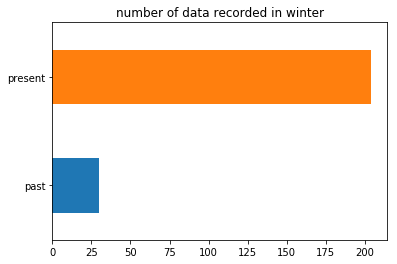

In [11]:
(pd.Series([(past_only_monarch_sdf['RecSeason'] == 4).sum(), (only_monarch_sdf['RecSeason'] == 4).sum()], index = ['past', 'present'])
 .plot(kind = 'barh', title = 'number of data recorded in winter'))

For visualization, the map below illustrates the very limited amount of data points are for winter monarch sightings made before 2010.

In [12]:
#will have to manually zoom in on webmap. Can't set the zoom level with code
past_winter_monarch = gis.content.get('130d18f1fd12412d9b7c5751d1bcf202')
wm_past_winter = WebMap(past_winter_monarch)
wm_past_winter

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

## Clustering of the sighting
**Thoughts:** Since trend (clustering + time/seasonality) is inexplicable. What about analyzing clustering without taking the seasonality into account at all? What would the clustering of points mean then?
<br>
Density of monarchs can be interpreted as the volume of butterfly traffic over some designated area every year. However, mere number of sightings within certain area is skewed by factors such as the magnitude of population within the area. Therefore normalization is required. In short, the question can be framed as the following
<br>
**Question:** What areas in the western US experiences the largest volume of monarch traffic every year. (note that I designate the 'area' mentioned above to be US counties)
<br>
**Definition:** Study areas will be US counties
<br>
**Plan for Analysis:** Overlay occurence points over US county Polygons, aggregate points by count, normalize the point count by dividing it with the population density of the county. 
<br>
**Expected Result:** Resultant choropleth map will be a approximated measurement of monarch traffic volume in each county
<br>
Below is the entire workflow visualized

Initial unnormalized (raw) density of monarch sightings

In [13]:
#visualizing raw density
monarch_location_density_id = 'c2fe1686f32a46e1863460b91134f04c'
monarch_heatmap = gis.content.get(monarch_location_density_id)
map_density = gis.map('Nevada')
map_density.add_layer(monarch_heatmap)
map_density.zoom = 5
map_density

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

Sighting is then aggregated over polygons of US counties by count.

In [14]:
from arcgis import aggregate_points
counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[0]
counties_lyr = counties_item.layers[0]
monarch_heat_lyr = monarch_heatmap.layers[0]
# counties_monarc_agg = aggregate_points(point_layer = monarch_heat_lyr, polygon_layer = counties_lyr,
#                                       keep_boundaries_with_no_points = False, output_name = 'monarch_count_per_county')
m_test = gis.map('California')
m_test.zoom = 5
monarch_county_id = 'f2009016fc4b403098c466b2fa65db84'
monarchs_per_county_lyr = gis.content.get(monarch_county_id).layers[0]
m_test.add_layer(monarchs_per_county_lyr)
m_test

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

In [15]:
monarch_county_sdf = monarchs_per_county_lyr.query().sdf
monarch_county_sdf.spatial.sr = {'wkid' : monarchs_per_county_lyr.query().spatial_reference['latestWkid']}
monarch_county_sdf['people_per_count'] = monarch_county_sdf['POP_SQMI'] / monarch_county_sdf['Point_Count']
#monarch_county_sdf.spatial.to_featurelayer(title = 'monarch_sighting_normalized', gis = gis, tags = ['project', 'monarch'])
monarch_normalized_id = 'cd56f2951c204fa7a4993e27976fa0c1'
monarch_normalized_lyr = gis.content.get(monarch_normalized_id).layers[0]
m_norm = gis.map('nevada')
m_norm.zoom = 5
m_norm.add_layer(monarch_normalized_lyr)
m_norm

MapView(layout=Layout(height='400px', width='100%'), zoom=5.0)

**Observation:** Counties colored in deeper red are ones with higher volume of monarch traffic. The map indicates that counties in oregon, idaho and Arizona are considered places with high monarch traffic.
<br>
**Further Question:** How is this traffic volume autocorrelated accross space?
<br>
We can visualize the autocorrelation by plotting the spatial lag of the feature

In [16]:
import pysal as ps

In [17]:
#Old codes

#monarch_county_sdf.spatial.to_featureclass('western_monarch/spatial_statistics/sighting_likelihood/norm_sighting.shp')
# shp_path = 'western_monarch/spatial_statistics/sighting_likelihood/norm_sighting.shp'
# shp = ps.lib.io.open(shp_path)
# ratio_gdf = gpd.read_file(shp_path)
# W = ps.lib.weights.Rook(shp)
# ratio_gdf['ratio'] =  ratio_gdf['people_per_'].apply(lambda x: 1/x)
# ratioLag = ps.lib.weights.lag_spatial(W, ratio_gdf.ratio)
# people_per_sighting['ratio_lag'] = ratioLag
# people_per_sighting.plot(column='ratio_lag', cmap='OrRd', scheme ='quantiles', k=10, legend=True, figsize=(10,10))
# ratio = ratio_gdf['ratio']
# b, a = np.polyfit(ratio, ratioLag, 1)

# f, ax = plt.subplots(1, figsize=(9, 9))

# plt.plot(ratio, ratioLag, '.', color='firebrick')

#  # dashed vert at mean of the last year's PCI
# plt.vlines(ratio.mean(), ratioLag.min(), ratioLag.max(), linestyle='--')
#  # dashed horizontal at mean of lagged PCI
# plt.hlines(ratioLag.mean(), ratio.min(), ratio.max(), linestyle='--')

# # red line of best fit using global I as slope
# plt.plot(ratio, a + b*ratio, 'r')
# plt.title('Moran Scatterplot')
# plt.ylabel('Spatial Lag of monarch count per human')
# plt.xlabel('ratio')
# plt.show()

/opt/conda/lib/python3.6/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 7 disconnected observations 
  Island ids: 9, 15, 22, 23, 113, 116, 133
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


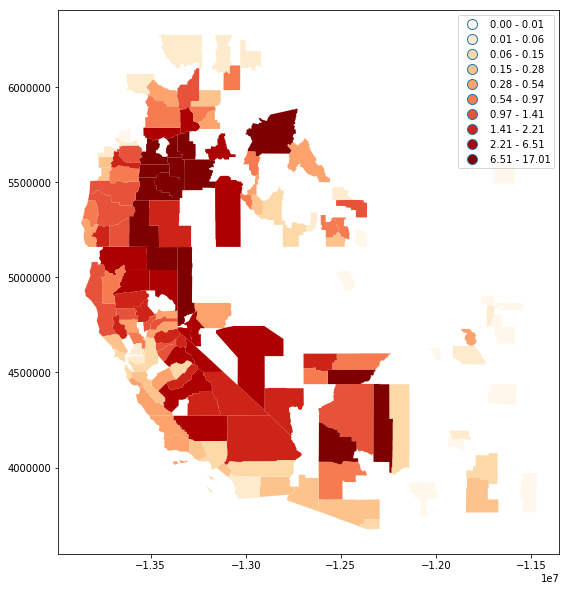

In [18]:
#remove the extreme values in the sdf (so that the eventual autocorrelation is not skewed)
ratio_sdf = monarch_county_sdf.copy()
ratio_sdf['ratio'] = ratio_sdf['people_per_count'].apply(lambda x: 1/x)
ratio = ratio_sdf['ratio']
ratio_sdf = ratio_sdf.copy().loc[(ratio - ratio.mean()) < (3 * ratio.std())]

#exporting the sdf
#ratio_sdf.spatial.to_featureclass('western_monarch/spatial_statistics/sighting_likelihood_trimmed/norm_sighting.shp')
#ratio_sdf.spatial.to_featurelayer(title = 'monarch_sighting_norm', gis = gis, tags = ['project', 'monarch'])

#a choropleth map that represents the spatial lag of the traffic volume between one county and its rook-neighbors
shp_path = 'western_monarch/spatial_statistics/sighting_likelihood_trimmed/norm_sighting.shp'
shp = ps.lib.io.open(shp_path)
ratio_gdf = gpd.read_file(shp_path)
W = ps.lib.weights.Rook(shp)
ratioLag = ps.lib.weights.lag_spatial(W, ratio_gdf.ratio)
ratio_gdf['ratio_lag'] = ratioLag
ratio_gdf.plot(column='ratio_lag', cmap='OrRd', scheme ='quantiles', k=10, legend=True, figsize=(10,10))

We can also explicitly plot the autocorrelation mathematically

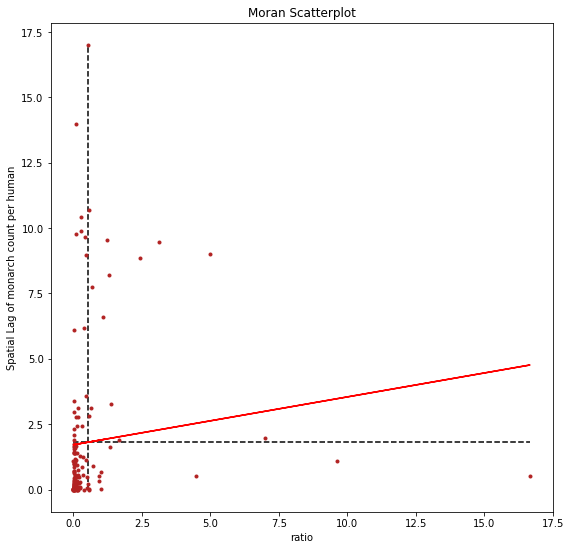

In [19]:
ratio = ratio_gdf.ratio
ratioLag = ratio_gdf.ratio_lag
b, a = np.polyfit(ratio, ratioLag, 1)

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(ratio, ratioLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(ratio.mean(), ratioLag.min(), ratioLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(ratioLag.mean(), ratio.min(), ratio.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(ratio, a + b*ratio, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of monarch count per human')
plt.xlabel('ratio')
plt.show()

In [20]:
I_ratio = ps.explore.esda.Moran(ratio.values, W)
(I_ratio.I, I_ratio.p_sim)

('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 113, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 133, ' is an island (no neighbors)')


(0.04386663124613975, 0.121)

**Observation:** Unintuitively, the traffic volume doesn't seem to have a strong autocorrelation across space due to the high p value. The high p value may be induced by two factors - 1. The choice of spatial weight  (rook instead of queen) 2. Existence of Islands

## Monarch Sighting Suitability Model
We just found out the volume of monarch traffic in each county. To go one step further, we can use interpolation to draw a suitability model for all the best sighting places within our interested geographical extent.
<br>
**Model Strucutre:** The structure of this suitability model is simple. It is the logical sum of the raster for monarch sightings and the raster for milkweed sightings.
<br>
**Workflow:** Both point layers involved can not be directly interpolated into raster because each point does not have a meaningful feature to be interpolated on. Therefore I first aggregate clusters of points into one point, giving them the z value of the size of the aggregation. Then interpolate on this transformed point layer. Below is the visualized execution process achieved by model builder in ArcGIS PRO. I created two resultant suitability model using IDW and Kriging for comparison of the two interpolation methods.
<img src = "Cache/model1_new.PNG">


In [21]:
m_idw = WebMap(gis.content.get('2f71a14e44eb484ab8e1e11664862e76'))
m_idw

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [22]:
m_kriging = WebMap(gis.content.get('16f61e1238624ff5ae6098041028a88b'))
m_kriging

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

**Observation:** For both models the degree of redness indicates the suitability for a butterfly lover to see monarchs (the redder the better). As for now I am not yet equipped with the knowledge to validate the two rasters, but by preliminary judging it seems that the one interpolated by Kriging generalizes better. The kriging model, however, wrongly includes the great basin area as a suitable place for monarch sighting (great basin cannot be a good place to see monarchs because it is an endorheic watershed, leading to an environment not suitable for milkweed growth.)

## Predicting Monarch Habitat with Spatially Explicit Model

**Giving raster predictive power:** The next step in the project is to attempt to predict potential monarch habitats based on our knowledge on the existing ones. To do so I am using different rasters and the help of MAXTENT model to fit a predictive suitability model that aims to predict locations of monarch habitat. In this project we will explore the ability to predict potential monarch habitat by its relationship with milkweed habitat.
<br>

**Model strucuture:** The suitability model for monarch habitat is defined as the sum of the suitability model of every milkweed specie in our geographical extent. MAXTENT will be used to fit a suitability model for the occurence of every specie of milkweed with geological rasters, and then will be used to fit the monarch occurence with the resultant milkweed suitability models.
<br>

**Feature selection:** Instead of fitting a suitability model for every specie of the milkweed, I pick only the top three milkweeds in the dataset - speciosa, fascicularis and subulata. Many species of milkweed only occurred very few times throughout the entire dataset. Below is the number of entries for the top five milkweed species in the dataset.

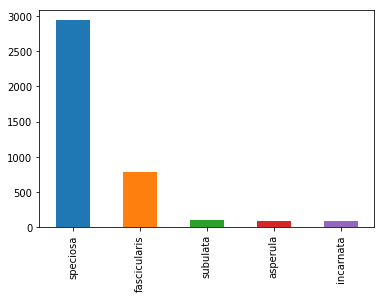

In [23]:
non_monarch_sdf['Species'].value_counts().iloc[:5].plot(kind = 'bar')

**Verifying and exception handling:** Plotting the top three milkweed out, we can see that they covers pretty much our entire study area with the exception of great basin area in Nevada. This exception is to be expected since great basin is an endorheic watershed, leading to different geographic outlook and one that is not suitable for either milkweed and monarch butterfly. 

In [24]:
WebMap(gis.content.get('5e7fff58e5b747a2b8391272705aa4cc'))

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

**Workflow**: Below is the final workflow (minus the MAXTENT part) for the monarch suitability model. Using the permutation importance devised by MAXTENT, geological rasters are combined by "weighting and rating" to form suitability model for each of the three species of milkweed. Then the three milkweed suitability model will be combined by "weighting and rating" with the similarly deduced permutation weighting to produce the final graph. 
<br>
Geographical informations that are used to produce suitability models for the three species are land cover (categorical data), climate water deficit, max and mean temperature during warmest season, percipitation amount during warmest season and distance to perennial water.
<img src = "Cache/habitat_suit_new.PNG">

**Result:** There are two things to note in this final result. There is computational problem encountered when running the above workflow, namely, one of the raster takes almost forever to normalize. Due to this problem we never get to finish running the model. An alternative workaround is attempted by skipping the normalization process; however, the result is undesirable due to the drastically different magnitude of cell values among different rasters. The product of the work around looks essentially identical to the raster "distance to perennial water" due to the high cell values in that raster.

In [25]:
WebMap(gis.content.get('68ca8bd91e5148e5a75bfe73c41d0c64'))

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

Above is the product of the failed workaround. The outlook of this raster is almost identical to the raster of distance to perennial water.

## 9.  Summary of Products and Results

To sum up the findings of this project are mainly: 
1. the traffic volume of monarchs in each county
1. The suitability model for monarch sightings
1. The habitat suitability model for western monarchs
<br>

The specific details of the findings are extensively discussed above.Please refer to section 8 for details.
<br>

**Implications:** both traffic volume and sighting suitability model can be utilized as a reference to designate public sighting spot and other cost-efficient programs that increase people's appreciation towards monarchs. Monarch preservation is an initiative that relies heavily on public effort. The initiative will benefit largely from public's increasing literacy in the long run. 
<br>On the other hand, the suitability model for monarch habitat is very powerful because of the ability to interpolate and help identify key areas to prioritize in rebuilding monarch habitat. 

## 10. Discussion
**Place of the finding in the bigger picture:** A huge caveat of this project is discovering that my attempt to create a predictive raster that interpolates potential habitat is something that has been done multiple times in the past. In fact, the owner of this dataset just published a paper around a week ago regarding this same approach. Upside is that I now have a solid reference to the exact approach but downside is that a huge part of this project is rendered derivative and unoriginal.
<br>

**Some decision makings during the project:** The specific decision makings are all discussed in the steps where they were made. To sum it up here, some decisions that worth examining are: 1. my decision to use Rook spatial weight during the autocorrelation analysis on traffic volume - this is partly intended due to the arragement of the county polygons but is also limited by my decision to aggregates point over counties instead of geographical extents of a different granularity. 2. My decision to choose only the top three milkweed species rather than some other number of them - This decision is not as controversial as the previous one because the three species really suffices for generality while saving an immersurable amount of computational power; However, the choice to leave out the rest of the species do have impact on the performance of the model. Maybe a better way is to aggregate the trivial species into larger groups based on some criteria.

## 11. Conclusion and Future Work
I started of the project not knowing what question to answer. As can be seen in my project proposal, I envisioned the project as an exploratory attempt rather than a prototype of some concrete solution. I am glad that, after multiple tackles at different aspect of the dataset, I am able to discover the possibility to utilize raster interpolation as a way of predicting. For further study on interpolating potential habitats, I can focus on producing rasters that focus on habitat suitability model for monarchs at **different life stage**. So far what I have done is creating a so called maximum suitability model that neglects the life stage of the monarch for every sighting record. Essentially the maximum suitability model, if works completely correctly, points out how many places, at most, are suitable for monarchs to live in. This maximum model devised in the project lacks nuance that accounts for the life stage of the monarch, which is of huge importance when tackling different detailed problem that hinders monarch population growth, such as parastic problem on certain milkweeds for monarch larvae, or humanly induced problems that kills off adult monarchs etc. 